We have a bunch of probably chess x-corners output by our ML detector. Let's do the following routine:

1. Take 4 random points, (check no 3 points are colinear, else retry) then warp them to a unity grid.
2. Count distances of each point to closest integer grid corner, sum of these will be the score.
3. Do this for an exhaustive set of random points?

The best score will likely be the correct transform to a chessboard.

Processing.
 - Total 40.56 ms, Saddle took 14.89 ms (434 pts), Predict took 3.45 ms


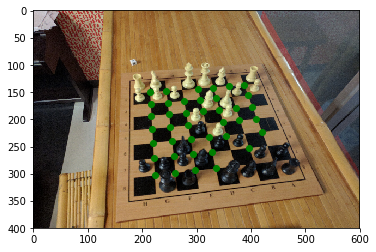

In [168]:
##### %pylab inline
from IPython.display import Image, display
import PIL.Image
import matplotlib.image as mpimg
import scipy.ndimage
import cv2 # For Sobel etc
import RunExportedMLOnImage
np.set_printoptions(suppress=True) # Better printing of arrays
plt.rcParams['image.cmap'] = 'jet' # Default colormap is jet

# img = PIL.Image.open('frame900.png')
img = PIL.Image.open('input/img_06.jpg')
if (img.size[0] > 1000):
    img = img.resize([600,400])
gray = np.array(img.convert('L'))

inlier_pts, outlier_pts, pred_pts, final_predictions, prediction_levels, tri, simplices_mask = RunExportedMLOnImage.processImage(gray)

# pts = np.loadtxt('example_pts.txt')
pts = inlier_pts
pts = pts[:,[1,0]] # Switch rows/cols to x/y for plotting on an image


plt.imshow(img)
plt.plot(pts[:,0],pts[:,1],'go');

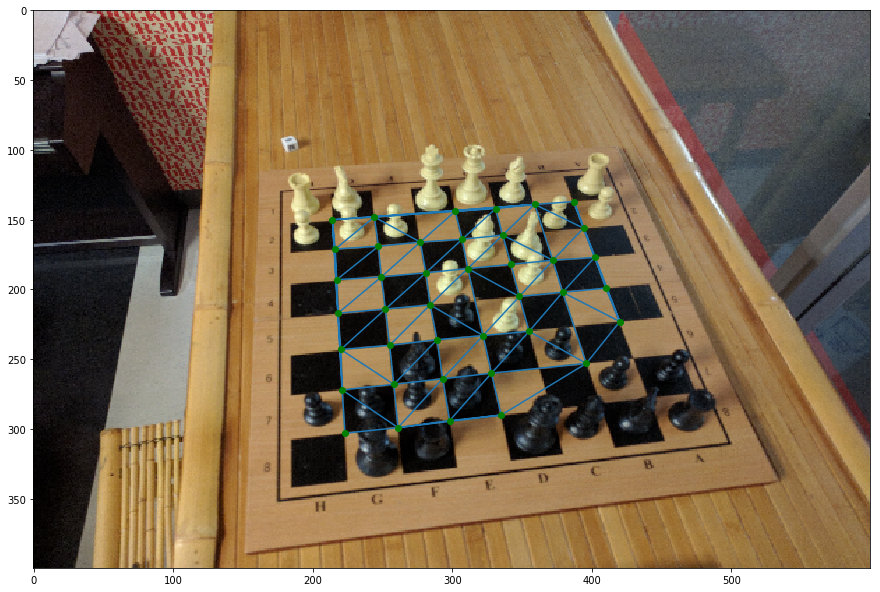

In [169]:
from scipy.spatial import Delaunay

tri = Delaunay(pts)
fig = plt.figure(figsize=(15,15))
plt.imshow(img)
plt.triplot(pts[:,0], pts[:,1], tri.simplices.copy())
plt.plot(pts[:,0], pts[:,1], 'go')

Threshold: 39.2938
Good Simplices 975/69


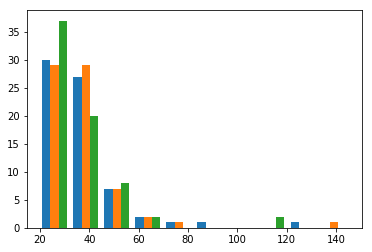

In [170]:
# print(dir(tri))
dists = np.zeros([tri.nsimplex, 3])
for i,triangle in enumerate(tri.points[tri.simplices]):
    # We want the distance of the edge opposite the vertex k, so r_k.
    r0 = (triangle[2,:] - triangle[1,:])
    r1 = (triangle[0,:] - triangle[2,:])
    r2 = (triangle[1,:] - triangle[0,:])
    dists[i,:] = np.linalg.norm(np.vstack([r0,r1,r2]), axis=1)
# print(dists)
plt.hist(dists)


threshold = 2*np.min(dists)
print("Threshold: %g" % threshold)
# Find edges that are too long (twice the median)
long_edges = dists > threshold
long_edged_simplices = np.any(long_edges,axis=1)
good_simplices = tri.simplices[~long_edged_simplices]
print("Good Simplices %d/%d" % (np.sum(good_simplices), tri.nsimplex))

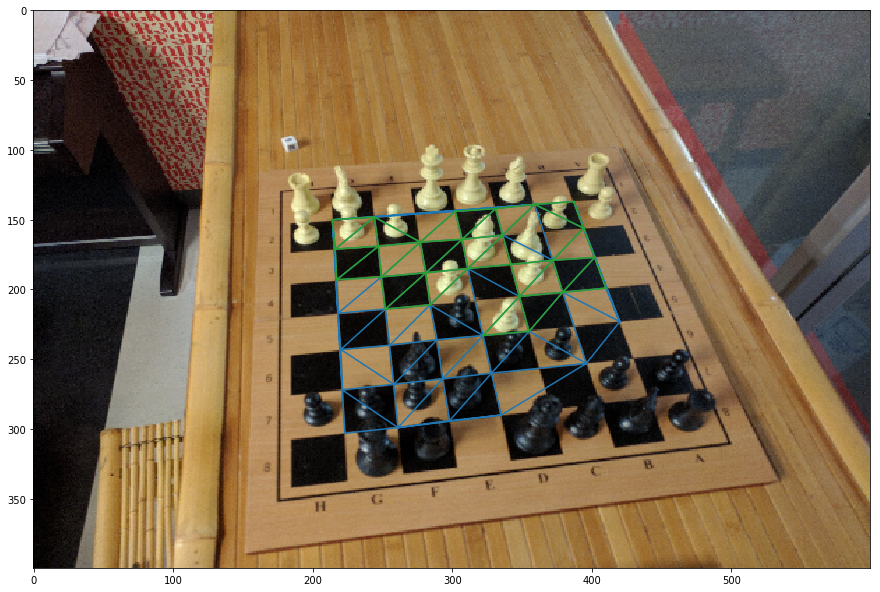

In [171]:
fig = plt.figure(figsize=(15,15))
plt.imshow(img)
plt.triplot(pts[:,0], pts[:,1], tri.simplices.copy())
plt.triplot(pts[:,0], pts[:,1], good_simplices);
# plt.plot(pts[:,0], pts[:,1], 'go')

Idea to find quads from triangles. For each triangle, the triangle that completes the quad should always be on the longest edge of the triangle and shares the two vertices of that edge. No image gradient checks needed.

In [172]:
def removeOutlierSimplices(tri):
    dists = np.zeros([tri.nsimplex, 3])
    for i,triangle in enumerate(tri.points[tri.simplices]):
        # We want the distance of the edge opposite the vertex k, so r_k.
        r0 = (triangle[2,:] - triangle[1,:])
        r1 = (triangle[0,:] - triangle[2,:])
        r2 = (triangle[1,:] - triangle[0,:])
        dists[i,:] = np.linalg.norm(np.vstack([r0,r1,r2]), axis=1)
    # Threshold based on twice the smallest edge.
    threshold = 2*np.min(dists)
    # Find edges that are too long
    long_edges = dists > threshold
    long_edged_simplices = np.any(long_edges,axis=1)
    # Good simplices are those that don't contain any long edges
    good_simplices_mask = ~long_edged_simplices
#     good_simplices = tri.simplices[good_simplices_mask]
    return dists, good_simplices_mask

def findQuadSimplices(tri, dists, simplices_mask=None):
    vertex_idx_opposite_longest_edge = dists.argmax(axis=1)
    # The neighboring tri for each tri about the longest edge
    potential_neighbor = tri.neighbors[
        np.arange(tri.nsimplex),
        vertex_idx_opposite_longest_edge]
    good_neighbors = []
    for i,j in enumerate(potential_neighbor):
        if j == -1:
            # Skip those that don't have a neighbor
            continue
        # If these tris both agree that they're good neighbors, keep them.
        if (potential_neighbor[j] == i and i < j):
#             print(i,j)
            if simplices_mask is not None:
                if simplices_mask[i]:
                    good_neighbors.append(i)
                if simplices_mask[j]:
                    good_neighbors.append(j)
            else:
                good_neighbors.extend([i,j])
    return good_neighbors

def findQuadSimplices(tri, dists, simplices_mask=None):
    vertex_idx_opposite_longest_edge = dists.argmax(axis=1)
    # The neighboring tri for each tri about the longest edge
    potential_neighbor = tri.neighbors[
        np.arange(tri.nsimplex),
        vertex_idx_opposite_longest_edge]
    good_neighbors = []
    for i,j in enumerate(potential_neighbor):
        if j == -1:
            # Skip those that don't have a neighbor
            continue
        # If these tris both agree that they're good neighbors, keep them.
        if (potential_neighbor[j] == i and i < j):
#             print(i,j)
            if simplices_mask is not None:
                if simplices_mask[i]:
                    good_neighbors.append(i)
                if simplices_mask[j]:
                    good_neighbors.append(j)
            else:
                good_neighbors.extend([i,j])
    return good_neighbors

In [173]:
pairings = set()
quads = []
for i, neighbors in enumerate(tri.neighbors):
    #pairs.extend([(i,x) for x in neighbors[neighbors != -1]])
    for k in range(3): # For each potential neighbor (3, one opposing each vertex of triangle)
        nk = neighbors[k]
        if nk != -1:
            # There is a neighbor, create a quad unless it already exists in set
            pair = (i, nk)
            reverse_pair = (nk, i)
            if reverse_pair not in pairings:
                # New pair, add and create a quad
                pairings.add(pair)
                # tri A, tri B, index of opposing vertex of triA
#                 print(i, nk, k)
                b = tri.simplices[i]
                d = tri.simplices[nk]                
                nk_vtx = (set(d) - set(b)).pop()
                insert_mapping = [2,3,1]
                b = np.insert(b,insert_mapping[k], nk_vtx)
                quads.append(b)
quads = np.array(quads)
print(len(pairings))
print(pairings)
print(quads)

99
set([(57, 61), (62, 64), (25, 31), (0, 7), (40, 41), (34, 35), (42, 43), (17, 46), (6, 7), (44, 45), (11, 12), (32, 38), (8, 60), (59, 68), (28, 31), (9, 14), (29, 30), (22, 39), (4, 35), (55, 56), (17, 18), (36, 41), (67, 68), (42, 52), (2, 37), (15, 16), (48, 50), (1, 21), (22, 23), (13, 26), (3, 28), (35, 51), (65, 66), (4, 42), (58, 59), (29, 32), (41, 43), (44, 46), (9, 20), (6, 11), (5, 17), (45, 47), (58, 60), (49, 52), (21, 30), (50, 51), (22, 29), (38, 39), (7, 8), (47, 62), (53, 61), (2, 33), (24, 25), (66, 67), (31, 33), (0, 53), (46, 47), (36, 65), (32, 33), (63, 68), (37, 66), (19, 58), (64, 65), (12, 14), (20, 67), (34, 50), (23, 43), (21, 23), (1, 4), (36, 39), (40, 49), (51, 52), (56, 63), (6, 8), (53, 54), (12, 19), (56, 59), (15, 44), (24, 26), (25, 27), (28, 30), (37, 38), (10, 27), (55, 57), (18, 64), (5, 48), (60, 61), (2, 10), (9, 10), (5, 15), (62, 63), (19, 20), (48, 49), (54, 57), (45, 55), (26, 27), (13, 14), (16, 34), (18, 40)])
[[12  0 25 19]
 [12  6  0 2

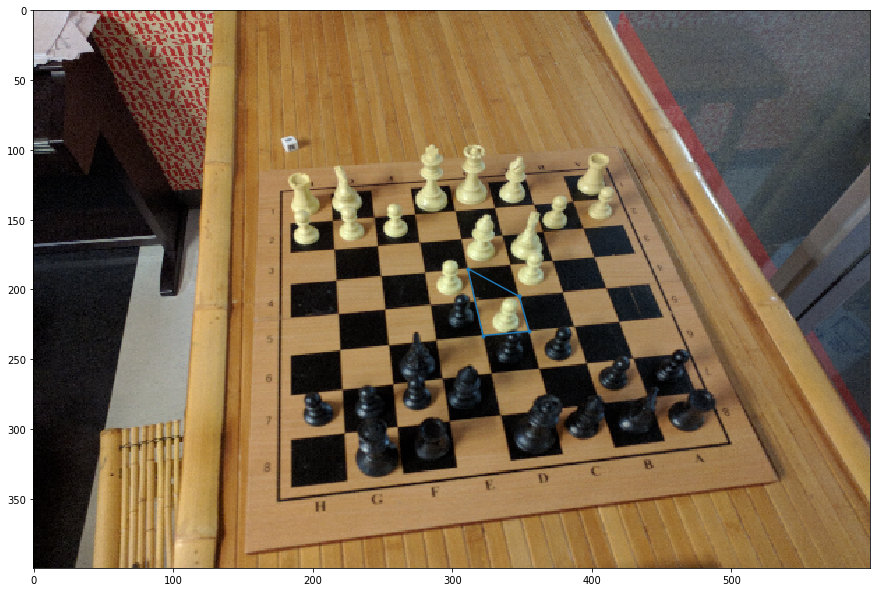

In [174]:
fig = plt.figure(figsize=(15,15))
plt.imshow(img)
for quad in pts[quads[36:37]]:
    plt.plot(quad[[0,1,2,3,0],0], quad[[0,1,2,3,0],1],'.-')

In [175]:
# print(~long_edged_simplices)
dists, good_simplices_mask = removeOutlierSimplices(tri)
good_neighbors = findQuadSimplices(tri, dists, good_simplices_mask)
print(good_neighbors)

[8, 60, 18, 64, 34, 50, 36, 41, 40, 49, 46, 47, 51, 52, 58, 59, 62, 63]


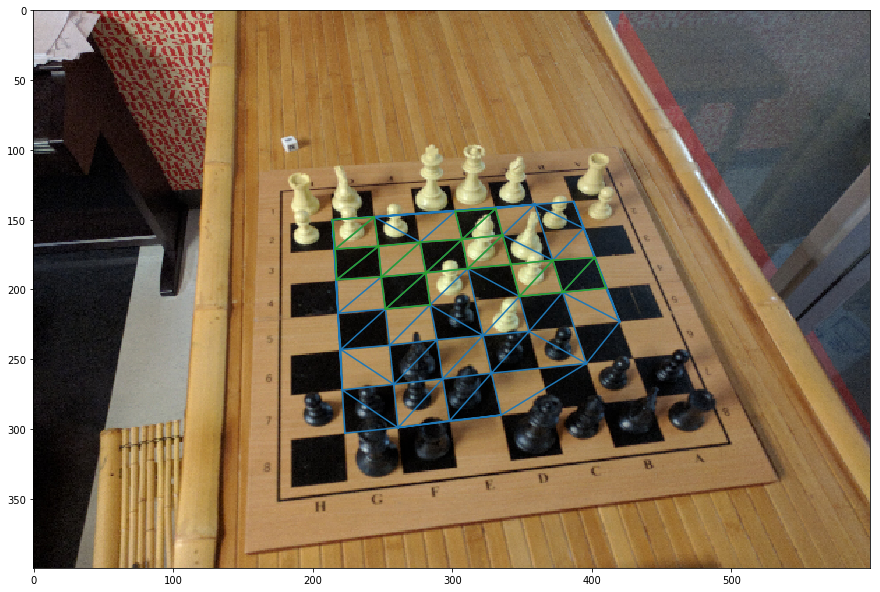

In [176]:
fig = plt.figure(figsize=(15,15))
plt.imshow(img)
plt.triplot(pts[:,0], pts[:,1], tri.simplices.copy()) # All
# plt.triplot(pts[:,0], pts[:,1], good_simplices); # Potential
plt.triplot(pts[:,0], pts[:,1], tri.simplices[good_neighbors]); # Good neighbor pairs
# plt.plot(pts[:,0], pts[:,1], 'go')

In [177]:
def countHits(given_pts, x_offset, y_offset):
    # Check the given integer points (in unity grid coordinate space) for matches
    # to an ideal chess grid with given initial offsets
    pt_set = set((a,b) for a,b in given_pts)
    [X,Y] = np.meshgrid(np.arange(7) + x_offset,np.arange(7) + y_offset)
    matches = 0
    # count matching points in set
    matches = sum(1 for x,y in zip(X.flatten(), Y.flatten()) if (x,y) in pt_set)
    return matches
        
def getBestBoardMatchup(given_pts):
    best_score = 0
    best_offset = None
    for i in range(7):
        for j in range(7):
            # Offsets from -6 to 0 for both
            score = countHits(given_pts, i-6, j-6)
            if score > best_score:
                best_score = score
                best_offset = [i-6, j-6]
    return best_score, best_offset

In [178]:
%%time 
print getBestBoardMatchup(pts_warped.round().astype(int))
# print countHits(pts_warped.round().astype(int), -3,-1)

(16, [-2, 0])
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11.2 ms


40
[[ 0.00304993 -0.00069894 -0.81922276]
 [-0.0035327  -0.00328036  1.90185317]
 [-0.00312695  0.00091242  1.        ]]


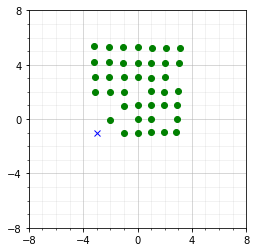

In [179]:
def scoreQuad(quad, pts):
    idealQuad = np.array([[0,1],[1,1],[1,0],[0,0]],dtype=np.float32)
    M = cv2.getPerspectiveTransform(quad.astype(np.float32), idealQuad)
    warped_to_ideal = cv2.perspectiveTransform(np.expand_dims(quad.astype(float),0), M)
    # Warp points and score error
    pts_warped = cv2.perspectiveTransform(np.expand_dims(pts.astype(float),0), M)[0,:,:]
    
    pts_warped_int = pts_warped.round().astype(int)
    
    # Count matches
    score, offset = getBestBoardMatchup(pts_warped.round().astype(int))
    
    # Sum of distances from closest integer value for each point
    # Use this error score for tie-breakers on score
    error_score = np.sum(np.linalg.norm((pts_warped - pts_warped.round()), axis=1))
    
    
    
    # Count duplicate points and add to error score because that's a bad sign
#     duplicates = len(pts_warped) - len(np.unique(pts_warped_int, axis=0))
#     error_score += duplicates * 0.2
    
    # Count points that are at integer points
    
#     board_size = pts_warped.astype(int).max(axis=0) - pts_warped.astype(int).min(axis=0)
#     print(board_size)
#     off_board = np.sum(board_size > 8)
#     print(board_size > 8)
#     off_board = np.sum(np.abs(pts_warped.astype(int)).flatten() > 7)
#     error_score += off_board
    
    return score, error_score, M, offset


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(-8, 9, 4)
minor_ticks = np.arange(-8, 9, 1)

ax.axis('square')
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

best_score = 0
best_error_score = None
best_M = None
best_quad = None
best_offset = None
for quad in pts[quads]:
    score, error_score, M, offset = scoreQuad(quad, pts)
    if score > best_score or (score == best_score and error_score < best_error_score):
        best_score = score
        best_error_score = error_score
        best_M = M
        best_quad = quad
        best_offset = offset

#         pts_warped = cv2.perspectiveTransform(np.expand_dims(pts.astype(float),0), M)[0,:,:]
#         plt.plot(pts_warped[:,0], pts_warped[:,1], '.')
#         print(M)
    
print(best_score)
print(M)

pts_warped = cv2.perspectiveTransform(np.expand_dims(pts.astype(float),0), best_M)[0,:,:]

plt.plot(pts_warped[:,0], pts_warped[:,1], 'go')
plt.plot(best_offset[0], best_offset[1], 'bx')

plt.show()

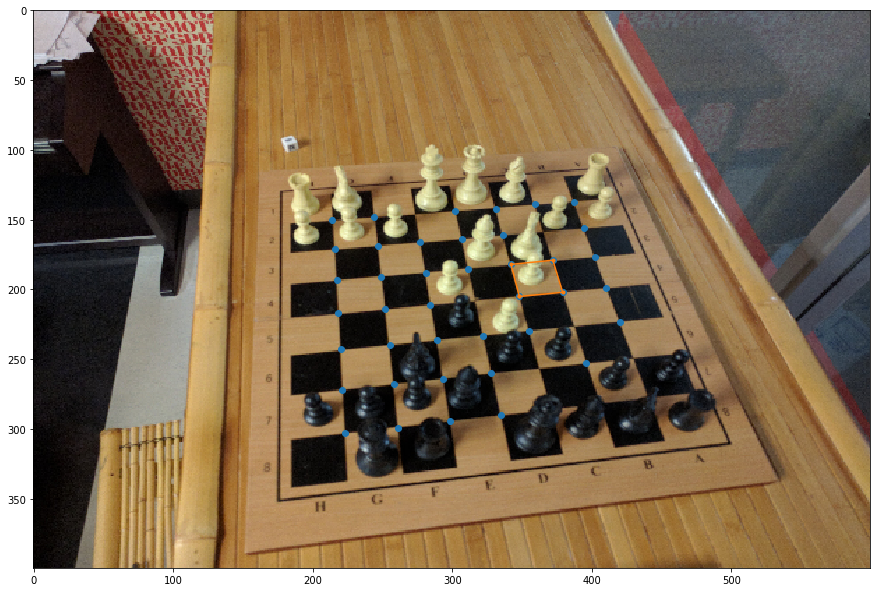

In [180]:
fig = plt.figure(figsize=(15,15))
plt.imshow(img)
plt.plot(pts[:,0], pts[:,1], 'o')
plt.plot(best_quad[[0,1,2,3,0],0], best_quad[[0,1,2,3,0],1],'.-')